# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function
import os;
from os.path import join as pathjoin;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;

#classifiers
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier;
from sklearn.ensemble import VotingClassifier

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;

In [2]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Darwin-17.4.0-x86_64-i386-64bit
NumPy 1.14.0
SciPy 1.0.0
Scikit-Learn 0.19.1


### paths configuration

In [3]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

In [4]:
pprinter = pprint.PrettyPrinter(indent=4)

## loading the dataset

In [5]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [6]:
problems = readCollectionsOfProblems(inputDir);

In [7]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [8]:
pd.DataFrame(problems).groupby(by='language').count()

,encoding,problem
language,,
en,2,2
fr,2,2
it,2,2
pl,2,2
sp,2,2


In [9]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [10]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [11]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [12]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [13]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [14]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [15]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [16]:
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC;
def runML(problem):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    #creating author profile
#     profile = defaultdict(unicode);
#     for text, author, _ in problem['candidates']:
#         profile[author]+=text;
    
#     train_docs   = list(profile.values())
#     train_labels = list(profile.keys())
    
    train_docs, train_labels, _  = zip(*problem['candidates'])
    
    problem['training_docs_size'] = len(train_docs);
    
    test_docs, _, test_filename = zip(*problem['unknown'])
    
    
    #feature extraction
    vectorizer = TfidfVectorizer(analyzer="char",min_df=0.3,max_df=1.0, lowercase=False, ngram_range=(3,5));
    train_mx   = vectorizer.fit_transform(train_docs);
    test_max   = vectorizer.transform(test_docs);
    
    scaler = MaxAbsScaler();
    train_mx = scaler.fit_transform(train_mx);
    test_max = scaler.transform(test_max);
    
    #selector = RFE(estimator=SVC(kernel="linear", C=1), step=0.05, verbose=False)
    #train_mx = selector.fit_transform(train_mx,train_labels);
    #test_max = selector.transform(test_max);
    
    reduction =PCA(int(train_mx.shape[1]*0.9))
    train_mx = reduction.fit_transform(train_mx.todense(),train_labels);
    test_max = reduction.transform(test_max.todense());
    
    #machine learning
    clf = LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg', C=0.5);
    #clf = AdaBoostClassifier(clf, n_estimators=50, learning_rate=0.01)
    #clf =  BaggingClassifier(clf, n_estimators=10, random_state=42)
    #clf = VotingClassifier([clf1,clf2] , voting='hard')
    clf.fit(train_mx,train_labels);
    
    train_pred=clf.predict(train_mx);
    test_pred=clf.predict(test_max);
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
#     f1,precision,recall,accuracy=eval_measures(
#             {str(i):label for i,label in enumerate(train_labels)},
#             {str(i):label for i,label in enumerate(train_pred)}
#     )
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };
    
    #evaluate_all(inputDir,outputDir, outputDir, instanceName)
    
    

In [17]:
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC;
from tempfile import mkdtemp
from shutil import rmtree


from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def runML(problem):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('vect', CountVectorizer(analyzer='char',max_df=1.0, ngram_range=(2,5))),
        ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=True)),
        ('dense',DenseTransformer()),
        ('scaler', MinMaxScaler()),
        ('transf', PCA()),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df': (0.0,  0.5),
        'transf__n_components':(0.5,0.9),
        'clf__C':(1,0.1,0.05),
    }
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #pipeline.set_params(best_parameters);
    pipeline.fit(train_docs, train_labels);
    
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

In [18]:
result = [];
for problem in problems:
    result.append(runML(problem));
pd.DataFrame(result)

Problem: problem00001,  language: en, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.5min finished


done in 104.221s

Best score: 0.807
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00002,  language: en, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   28.4s finished


done in 30.204s

Best score: 0.943
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.5
Problem: problem00003,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.7min finished


done in 114.132s

Best score: 0.779
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00004,  language: fr, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   29.8s finished


done in 34.100s

Best score: 0.857
Best parameters set:
	clf__C: 0.1
	transf__n_components: 0.5
	vect__min_df: 0.0
Problem: problem00005,  language: it, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.8min finished


done in 120.999s

Best score: 0.707
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00006,  language: it, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   33.3s finished


done in 37.999s

Best score: 0.914
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00007,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.5min finished


done in 171.146s

Best score: 0.821
Best parameters set:
	clf__C: 0.1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00008,  language: pl, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   45.7s finished


done in 48.280s

Best score: 0.800
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.5
Problem: problem00009,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.0min finished


done in 135.558s

Best score: 0.871
Best parameters set:
	clf__C: 0.1
	transf__n_components: 0.9
	vect__min_df: 0.0
Problem: problem00010,  language: sp, 
Performing grid search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   40.5s finished


done in 47.310s

Best score: 0.886
Best parameters set:
	clf__C: 1
	transf__n_components: 0.9
	vect__min_df: 0.0


,AuthorCount,language,macro-f1,macro-precision,macro-recall,micro-accuracy,problem-name,train_doc_size
0,20,en,0.621,0.626,0.725,0.648,problem00001,140
1,5,en,0.629,0.647,0.700,0.667,problem00002,35
2,20,fr,0.726,0.712,0.792,0.755,problem00003,140
3,5,fr,0.663,0.747,0.713,0.571,problem00004,35
4,20,it,0.641,0.617,0.745,0.762,problem00005,140
5,5,it,0.603,0.596,0.711,0.848,problem00006,35
6,20,pl,0.543,0.596,0.638,0.563,problem00007,140
7,5,pl,0.704,0.680,0.889,0.667,problem00008,35
8,20,sp,0.796,0.795,0.864,0.812,problem00009,140
9,5,sp,0.831,0.821,0.853,0.875,problem00010,35


In [19]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.675700
std,0.089041
min,0.543000
25%,0.623000
50%,0.652000
75%,0.720500
max,0.831000


In [20]:
pd.DataFrame(result)[['macro-f1']].describe()

,macro-f1
count,10.000000
mean,0.675700
std,0.089041
min,0.543000
25%,0.623000
50%,0.652000
75%,0.720500
max,0.831000


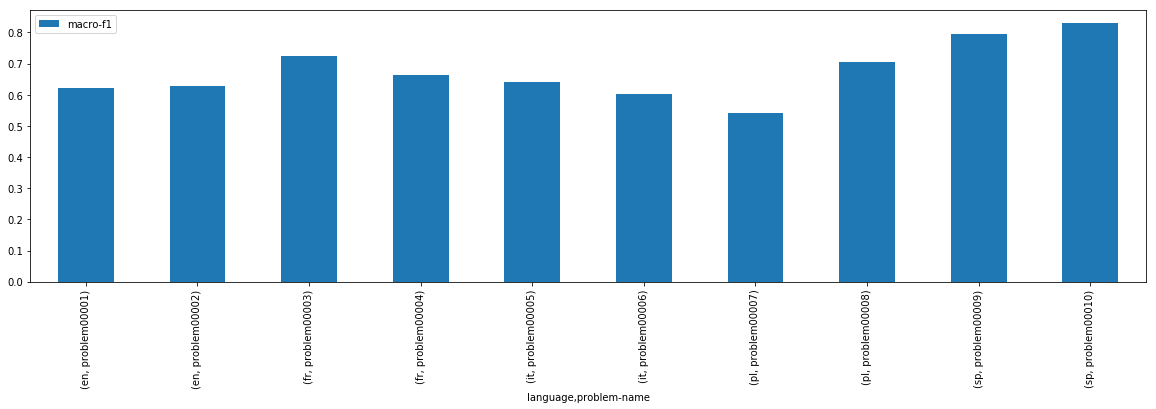

In [21]:
pd.DataFrame(result)\
    .sort_values(by=['language','problem-name'])[['language','problem-name','macro-f1']]\
    .plot(kind='bar', x=['language','problem-name'], legend=True, figsize=(20,5))

In [22]:
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC;
from tempfile import mkdtemp
from shutil import rmtree


from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def runML(problem):
    print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    cachedir = mkdtemp()
    pipeline = Pipeline([
        ('vect', CountVectorizer(analyzer='char',max_df=1.0, ngram_range=(2,5))),
        ('tfidf', TfidfTransformer(norm='l2', sublinear_tf=True)),
        ('dense',DenseTransformer()),
        ('transf', PCA(0.9)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ], memory=cachedir)
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df': (0.0,  0.5),
        'tfidf__sublinear_tf':(False, True),
        'clf__C':(1,0.1,0.05),
    }
    
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #pipeline.set_params(best_parameters);
    pipeline.fit(train_docs, train_labels);
    
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append(
                {'unknown-text': test_filename[i],
                 'predicted-author': v
                }
                )
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
        #allProblems.extend(out_data)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    rmtree(cachedir)
    return {
                'problem-name'   : problem['problem'],
                "train_doc_size":len(train_docs),
                "language":problem['language'],
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                'AuthorCount':len(set(train_labels))
        };

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [23]:
from gensim.models import Word2Vec;

In [24]:
class NgramSplitter(object):
    def __init__(self, text, ngram=(3,3), vocabulary=None):
        self.text = text
        self.ngram_min = ngram[0]
        self.ngram_max = ngram[1];
        self.vocabulary = vocabulary;
    
    def text2ngrams(self,text):
        vect = [
            text[t:t+j]
                for t in xrange(len(text)-self.ngram_max+1)
                for j in xrange(self.ngram_min, self.ngram_max+1)
        ]
        
        if self.vocabulary is not None:
            return [word for word in vect if word in self.vocabulary];
        else:
            return [word for word in vect if word]
 
    def __iter__(self):
        if isinstance(self.text,list):
            for s in self.text:
                yield self.text2ngrams(s);
        elif isinstance(self.text,str) or isinstance(self.text,unicode):
            yield self.text2ngrams(self.text);

In [25]:
def simpleCosine(a, b):
    '''
    calculates cosine between array a and b.
    This function is used because sklearn similiraty function compares all elements vs all elements
    what will not be used. So this function becames handy.
    '''
    a = a / np.sqrt(np.sum(a **2));
    b = b / np.sqrt(np.sum(b **2));
    cos = np.sum(np.array(a) * np.array(b));
    return cos;

###  parameters

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Word2VecClassifier(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""

    def __init__(self, min_count =2, embeddingSize window=5, algorithm = 0, iter ):
        """
        Called when initializing the classifier
        """
        self.algorithm   = algorithm
        self.min_count   = min_count
        self.embeddingSize = embeddingSize
        self.window = window
        self.iter  = iter

        # THIS IS WRONG! Parameters should have same name as attributes
        self.differentParam = otherParam
        

    def _buildVectorModel(self, document):
            model = Word2Vec(
                NgramSplitter(doc,ngram=ngram, vocabulary=vectorizer.vocabulary_),
                sg= self.algorithm,
                iter = self.iter,        
                min_count= self.min_count,
                window=self.window,
                size=self.embeddingSize,
                seed=0
            );
            return model.wv;
        


    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """

        assert (type(self.intValue) == int), "intValue parameter must be integer"
        assert (type(self.stringParam) == str), "stringValue parameter must be string"
        assert (len(X) == 20), "X must be list with numerical values."
        
        

        
        

        self.treshold_ = (sum(X)/len(X)) + self.intValue  # mean + intValue

        return self

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return( True if x >= self.treshold_ else False )

    def predict(self, X, y=None):
        try:
            getattr(self, "treshold_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return([self._meaning(x) for x in X])

    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 
A

In [56]:
ngram = (3,5);
embeddingSize  = 500
problem = problems[8];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

Problem: problem00009,  language: sp, 


the authors profile is used to generate author word vectors

In [57]:
#creating author profile
profile = defaultdict(unicode);
for text, author, _ in problem['candidates']:
    profile[author]+=text;

Data sets

In [58]:
profile_docs   = list(profile.values())
profile_labels = list(profile.keys())

In [59]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [60]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [61]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

Using count vectorizer to create a fixed vocabulary

In [62]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=ngram, min_df=0.6, max_df=1.0, lowercase=False)
counts = vectorizer.fit_transform(profile_docs);

In [63]:
vocabulary = dict(zip(
    vectorizer.vocabulary_,
    np.array(counts.sum(axis=0)).flatten()
)
)
len(vectorizer.vocabulary_)

13874

In [83]:
#transform a document into a word vector using CBOW
def doc2vectors(doc):
    model = Word2Vec(
        NgramSplitter(doc,ngram=ngram, vocabulary=vectorizer.vocabulary_),
        sg=0,
        iter = 5,        
        min_count=2,
        window=5,
        size=embeddingSize,
        seed=0
    );
    return model.wv;

### profile vector represent each author in the embedding space

In [84]:
profileVectors = {author: doc2vectors(profile[author]) for author in profile};

#### testing author vector against internal documents

In [85]:
documentVectors =[doc2vectors(doc) for doc in train_docs];

In [86]:
def compare(profileVectors, doc):
    vocabDoc = set(doc.vocab.keys());
    
    metrics = [];
    
    for author in profileVectors:
        authorVocab = set(profileVectors[author].vocab.keys());
        intersect = vocabDoc & authorVocab;
        union = len(vocabDoc | authorVocab);
        jaccard = 1.0*len(intersect) / union;
        
        cosine = [
            simpleCosine(doc[word],profileVectors[author][word])
            for word in intersect
        ];
            
        metrics.append({
            'candidate':author,
            'jaccard'  :jaccard,
            'lenIntersect':len(intersect),
            'lenUnion'    :union,
            'lenMax': max(len(authorVocab), len(vocabDoc)),
            'distanceVector'    :np.sum(cosine)            
        })
    #softmax norm
    cosine = np.array([c['distanceVector'] for c in metrics ]);
    #minMax
    cosine = (cosine - np.min(cosine))/(np.max(cosine) - np.min(cosine));
    cosine = np.exp(cosine)/np.sum(np.exp(cosine));
    
    #appending normalized sum of distance
    for i,c in enumerate(metrics):
        c.update({'distanceVectorNorm': cosine[i]})
    
    return metrics; 

##### testing one document

In [87]:
train_doc_index = 4;
print ("Expected answer %s" % train_labels[train_doc_index])
metrics = compare(profileVectors, documentVectors[train_doc_index]);

Expected answer candidate00001


In [88]:
pd.DataFrame(metrics).sort_values(by='distanceVectorNorm', ascending=False).head()

,candidate,distanceVector,distanceVectorNorm,jaccard,lenIntersect,lenMax,lenUnion
2,candidate00001,1902.554443,0.106199,0.215919,1907,8832,8832
13,candidate00019,1753.480957,0.056641,0.202535,1758,8531,8680
11,candidate00018,1752.481201,0.056403,0.189495,1757,9122,9272
5,candidate00006,1746.286377,0.054948,0.207563,1751,8280,8436
16,candidate00012,1735.456299,0.052495,0.187905,1740,9093,9260


In [89]:
def predict(profileVectors, documentVectors):
    predictions = [];
    
    for document in documentVectors:
        metrics = compare(profileVectors, document);
        metrics.sort(key=lambda k: (k['distanceVectorNorm'])/1.0, reverse=True  )
        predictions.append(metrics[0]['candidate']);
    return predictions;

In [90]:
pred =predict(profileVectors, documentVectors)
#print (" acurácia de treinamento %s" % (np.sum(np.array(train_labels) == np.array(pred)/len(np.array(pred)) )))

### Teste

In [91]:
documentVectorsTest =[doc2vectors(doc) for doc in test_docs];

analyzing one incorrect answer

In [92]:
test_index = 74
print ("Expected answer (candidate with highest score) %s"% test_labels[test_index])
df= pd.DataFrame(compare(profileVectors, documentVectorsTest[test_index]))\
    .sort_values(by='distanceVectorNorm',ascending=False)\
    .head(35) \
    .reset_index();
df

Expected answer (candidate with highest score) candidate00018


,index,candidate,distanceVector,distanceVectorNorm,jaccard,lenIntersect,lenMax,lenUnion
0,18,candidate00011,1280.080322,0.071748,0.147876,1288,8588,8710
1,19,candidate00015,1276.178711,0.067942,0.151451,1284,8352,8478
2,15,candidate00013,1272.161987,0.064236,0.145059,1280,8694,8824
3,2,candidate00001,1266.388306,0.059259,0.142061,1274,8832,8968
4,11,candidate00018,1263.288696,0.056749,0.137242,1271,9122,9261
5,10,candidate00008,1260.380981,0.054490,0.151078,1268,8251,8393
6,12,candidate00016,1256.444580,0.051575,0.142182,1264,8744,8890
7,0,candidate00003,1256.136963,0.051354,0.142631,1264,8716,8862
8,16,candidate00012,1254.283447,0.050042,0.136565,1262,9093,9241
9,17,candidate00010,1253.342529,0.049388,0.144478,1261,8579,8728


In [93]:
prob = []
documentVectorsTestMetrics = [];
for t,truth,instance in zip(documentVectorsTest,test_labels, test_filename):
    for i,j in enumerate(sorted(compare(profileVectors, t), key=lambda x: x['distanceVector'], reverse=True)):
        j.update({"truth":truth, 'instance':instance, 'distanceToTruth':i});
        
        jcopy = j.copy();
        jcopy.update({'correct':truth == j['candidate']})
        documentVectorsTestMetrics.append(jcopy)
        
        if truth != j['candidate']:
            continue;
        
        prob.append(j);

In [94]:
df = pd.DataFrame(prob)[
    ['instance','distanceToTruth','truth','distanceVector','distanceVectorNorm','jaccard','lenIntersect','lenMax','lenUnion']
].sort_values(by=['instance','truth','distanceVector'], ascending=False)
df

,instance,distanceToTruth,truth,distanceVector,distanceVectorNorm,jaccard,lenIntersect,lenMax,lenUnion
81,unknown00117.txt,1,candidate00011,1945.575928,0.074300,0.222248,1950,8588,8774
84,unknown00116.txt,0,candidate00011,1884.058105,0.089242,0.217117,1890,8588,8705
93,unknown00115.txt,0,candidate00013,1775.847534,0.075837,0.201607,1781,8694,8834
92,unknown00114.txt,7,candidate00006,1710.543457,0.058028,0.202695,1715,8280,8461
74,unknown00113.txt,4,candidate00018,1263.288696,0.056749,0.137242,1271,9122,9261
71,unknown00112.txt,3,candidate00011,1691.958984,0.062346,0.193523,1697,8588,8769
62,unknown00111.txt,1,candidate00001,1935.872314,0.071593,0.215490,1942,8832,9012
63,unknown00110.txt,1,candidate00001,1770.363770,0.076118,0.197443,1776,8832,8995
51,unknown00109.txt,0,candidate00001,1723.739258,0.074724,0.192295,1727,8832,8981
52,unknown00108.txt,10,candidate00011,1699.799683,0.049176,0.194679,1705,8588,8758


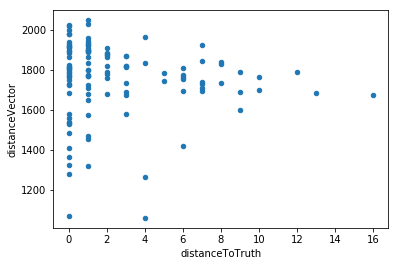

In [95]:
df = pd.DataFrame(prob).sort_values(by=['distanceVector','jaccard'], ascending=False)
df.plot.scatter(x='distanceToTruth', y='distanceVector')

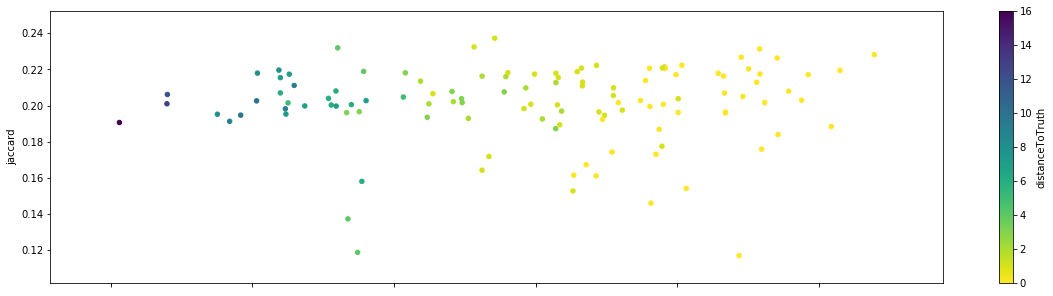

In [96]:
df = pd.DataFrame(prob)
#df.distanceToTruth = np.log(df.distanceToTruth+1)
#df.distanceToTruth = df.distanceToTruth/df.distanceToTruth.max()
df.plot.scatter(
    x='distanceVectorNorm',
    y='jaccard',c='distanceToTruth',
    figsize=(20,5),
    #xlim=(0,0.15), ylim=(0.025,0.20),
    cmap='viridis_r')

In [97]:
df = pd.DataFrame(prob).sort_values(by=['instance','truth','distanceVector'], ascending=False)
df = df.groupby(by='distanceToTruth').size().reset_index();
df.columns=['distanceToTruth', 'counter']
df['cumm'] = df['counter'].cumsum();
df['cumm_inve'] = df['cumm'].max() - df['cumm'];
df['acc_acuracy'] = df['cumm'] / df['cumm'].max()
df

,distanceToTruth,counter,cumm,cumm_inve,acc_acuracy
0,0,41,41,76,0.350427
1,1,28,69,48,0.589744
2,2,10,79,38,0.675214
3,3,9,88,29,0.752137
4,4,4,92,25,0.786325
5,5,2,94,23,0.803419
6,6,6,100,17,0.854701
7,7,6,106,11,0.905983
8,8,3,109,8,0.931624
9,9,3,112,5,0.957265


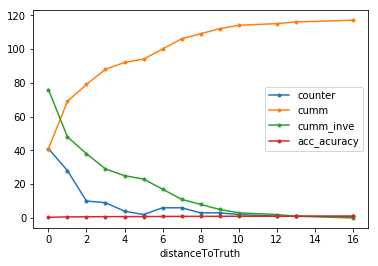

In [98]:
df.plot.line(x='distanceToTruth',marker='.');

In [99]:
predTest =predict(profileVectors, documentVectorsTest)

In [100]:
df = pd.DataFrame(zip(test_labels, predTest), columns=['Truth', 'Pred'])
df['comp'] = df.Truth == df.Pred
df.groupby(by='comp').count()

,Truth,Pred
comp,,
False,76,76
True,41,41


In [101]:
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, predTest)  })

In [102]:
pd.DataFrame([{
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }])

,macro-f1,macro-precision,macro-recall,micro-accuracy
0,0.314,0.405,0.366,0.35


In [103]:
df = pd.DataFrame(documentVectorsTestMetrics)
len(df[df.correct & (df.distanceToTruth==0)].truth.unique())

14

# Abordagem 2

In [ ]:
embeddingSize  = 100

In [ ]:
class AuthorNgram(object):
    def __init__(self, text, label, vocabulary=None):
        self.text = text;
        self.label = label;
        self.ngram_min = 3;
        self.ngram_max = 5;
        self.vocabulary = vocabulary;
        self.window = 3;
    
    def text2ngrams(self,text):
        vect = [
            text[t:t+j]
                for t in xrange(len(text)-self.ngram_max+1)
                for j in xrange(self.ngram_min, self.ngram_max+1)
        ]
        
        if self.vocabulary is not None:
            return [word for word in vect if word in self.vocabulary];
        else:
            return [word for word in vect if word]
        
    def textPlusAuthor(self,text,label):
        vect = self.text2ngrams(text);
        vect = [
                vect[t:t+self.window] +[label]+ vect[t+self.window:t+self.window*2] 
                for t in xrange(len(vect)-2*self.window+1)
        ];
        return vect;
    
    def __len__(self):
        l = 0;
        for i in range (self.ngram_min, self.ngram_max +1):
            l += len(self.text) - i
        return l
 
    def __iter__(self):
        if isinstance(self.text,list):
            for s in self.text:
                for vect in self.textPlusAuthor(s, self.label):
                    yield vect;
        elif isinstance(self.text,str) or isinstance(self.text,unicode):
                for vect in self.textPlusAuthor(self.text, self.label):
                    yield vect;

In [ ]:
for s in AuthorNgram(['a casa caiu'],"_text_"):
    print (s);

In [ ]:

for i,s in enumerate(AuthorNgram(train_docs[0],"_text_")):
    print (s);
    if i == 20:
        break;

In [ ]:
def getEmbedding(doc, label):
    model = Word2Vec(
        sg=0,
        min_count=2,
        size=embeddingSize,
        seed=0
    );
    corpus_count = len(AuthorNgram(doc,label, vocabulary=vocabulary.keys()))
    model.build_vocab_from_freq(vocabulary)
    model.train(
        AuthorNgram(doc,label, vocabulary=vocabulary.keys()),
        total_examples=corpus_count,
        epochs=10
    )
    
    
    return model.wv[label]

In [ ]:
authorEmbedding = {
    author:getEmbedding(profile[author], author)
    for author in profile
    
};

In [ ]:
authorVectors= np.vstack(authorEmbedding.values())

In [ ]:
trainVectors = [getEmbedding(doc, "_train"+str(i)+"_") for i,doc in enumerate(train_docs)]
testVectors  = [getEmbedding(doc, "_test"+str(i)+"_") for i,doc in enumerate(test_docs)]

In [ ]:
trainVectors =np.vstack(trainVectors)
testVectors  =np.vstack(testVectors)

In [ ]:
trainPred = cosine_similarity(normalize(trainVectors,'l2'), normalize(authorVectors,'l2'))
testPred  = cosine_similarity(normalize(testVectors,'l2'), normalize(authorVectors,'l2'))

In [ ]:
def cosineToLabels(matrix, labels):
    #min_ = matrix.min(axis=1, keepdims=True)
    #max_ = matrix.max(axis=1, keepdims=True)
    #matrix = (matrix - min_)/(max_ - min_);
    length = len(labels);
    labels = np.array(labels);
    temp = (length-1-np.argsort(matrix, axis=1))==0
    
    return [labels[i][0] for i in temp ];

In [ ]:
trainPredLabels = cosineToLabels(trainPred,authorEmbedding.keys())
testPredLabels = cosineToLabels(testPred,authorEmbedding.keys())

In [ ]:
np.sum(np.array(train_labels) == np.array(trainPredLabels))

In [ ]:
trainPred.min(axis=1, keepdims=True)

In [ ]:
zip(train_labels, trainPredLabels)

# Abordagem 2 - por LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD;
from scipy.sparse.linalg import svds

In [ ]:
class LSAWordVec:
    def __init__(self):

In [ ]:
lsaVectorizer = TfidfVectorizer(analyzer="char", ngram_range=ngram, min_df=0.4, max_df=1.0, lowercase=False)
profileLSAVectors = lsaVectorizer.fit_transform([profile[author] for author in profile]);

In [ ]:
profileLabels =[author for author in profile]

In [ ]:
np.shape(profileLSAVectors)

In [ ]:
svd = TruncatedSVD(n_components=20, random_state=42, n_iter=10)

In [ ]:
profileLSAVectors.shape

In [ ]:
svdProfile = svd.fit_transform(profileLSAVectors)

In [ ]:
np.shape(svdProfile)

In [ ]:
documentVectorsLSA = svd.transform(lsaVectorizer.transform(train_docs));
documentVectorsTest = svd.transform(lsaVectorizer.transform(test_docs));

In [ ]:
def compareLSA(svdProfile, doc):
    metrics = [];
    
    for author in profileVectors:
        authorVocab = (profileVectors[author] >0).sum();
        intersect = (profileVectors[author] >0) & (doc > 0)>0;
        union = len(vocabDoc | authorVocab);
        jaccard = 1.0*len(intersect) / union;
        
        cosine = [
            simpleCosine(doc[word],profileVectors[author][word])
            for word in intersect
        ];
            
        metrics.append({
            'candidate':author,
            'jaccard'  :jaccard,
            'lenIntersect':len(intersect),
            'lenUnion'    :union,
            'lenMax': max(len(authorVocab), len(vocabDoc)),
            'distanceVector'    :np.sum(cosine)            
        })
    #softmax norm
    cosine = np.array([c['distanceVector'] for c in metrics ]);
    #minMax
    cosine = (cosine - np.min(cosine))/(np.max(cosine) - np.min(cosine));
    cosine = np.exp(cosine)/np.sum(np.exp(cosine));
    
    #appending normalized sum of distance
    for i,c in enumerate(metrics):
        c.update({'distanceVectorNorm': cosine[i]})
    
    return metrics; 

In [ ]:
def predictLSA(svdProfile, documentVectors):
    cosines = cosine_similarity(documentVectors,svdProfile)
    sortedIndex = np.argsort(svdTrainPred, axis=1);
    
    labels = np.array(profileLabels);
    
    
    
    predictions = [];
    
    for i,cosine_ in enumerate(cosines):
        
        l       = labels[sortedIndex];
        cosine_ = cosine_[i][sortedIndex[i]];
        
        metrics= [{
            'candidate':a,
            'distanceToTruth':len(labels) - ii,
            'distanceVector' :c            
        }  for a,c, ii in zip(l, cosine_, sortedIndex[i])]
        
        metrics.sort(key=lambda k: (k['distanceToTruth'])/1.0, reverse=True  )
        predictions.append(metrics[0]['candidate']);
    return predictions;

In [ ]:
svdTrainPred = cosine_similarity(documentVectorsLSA,svdProfile)

In [ ]:
predictLSA(svdProfile,documentVectorsLSA )

In [ ]:
np.reshape(np.round(np.random.rand(30)*100), (10,3))

In [ ]:
predTestLSA = [np.array(profileLabels)[v][0] for v in  (np.argsort(svdTrainPred, axis=1)==19)]

In [ ]:
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, predTestLSA)  })
pd.DataFrame([{
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }])

In [ ]:
svdTrainPred[1]

In [ ]:
np.argsort(svdTrainPred, axis=1)[1]

In [ ]:
t = [list('casa sapato'),list('terra casa, sapato')]